# Visualise data thorugh the AudioProcessor
This notebook is used to visually assess the feature extraction made to the target and noise data

## Understanding MFCCs and Temporal Resolution

First, let me explain what MFCCs are and what the parameters mean:

**MFCC (Mel-Frequency Cepstral Coefficients)** is a popular representation of audio signals that captures the spectral envelope in a way that's similar to human hearing perception.

The parameters that control resolution are:

1. **n_mfcc** (vertical resolution): Number of MFCC coefficients
   - Higher values (e.g., 20, 40) capture more spectral detail
   - Lower coefficients represent the general shape of the spectrum, while higher ones capture fine details

2. **hop_length** (temporal resolution): Number of samples between successive frames
   - Smaller values = higher temporal resolution (more time frames)
   - Default is 512

3. **n_fft**: Window size for FFT in samples
   - Affects the frequency vs. time resolution tradeoff
   - Larger window = better frequency resolution but worse time resolution

### Section 1: Setup and Imports

In [60]:
# Import necessary libraries
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import random
from IPython.display import Audio

# Add the src directory to the path so we can import the modules
sys.path.append('../')

# Import our audio processing classes
from src.anemonefish_acoustics.data_processing.data_preprocessing import AudioProcessor, DatasetBuilder, AnemoneMetadataParser

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

# Initialize DatasetBuilder with your data directories
dataset_builder = DatasetBuilder(
    processed_wavs_dir='../data/processed_wavs',  # Adjust paths as needed
    noise_dir='../data/noise',
    noise_chunked_dir='../data/noise_chunked',
    cache_dir='../data/cache'
)

### Section 2: Visualizing Anemonefish Data

In [46]:
# List all anemonefish files
anemonefish_files = dataset_builder.list_anemonefish_files()
print(f"Found {len(anemonefish_files)} anemonefish audio files")

# Select a few random files to analyze
num_samples = min(5, len(anemonefish_files))
selected_anemonefish = random.sample(anemonefish_files, num_samples)

# Display selected files
for i, file_path in enumerate(selected_anemonefish):
    print(f"File {i+1}: {os.path.basename(file_path)}")

Found 135 anemonefish audio files
File 1: social-FirstM-M-NR-R1-R2-Social_B47_2023_20230330-010005-FirstM-B47-M-NR-withlabels_107367_107502.wav
File 2: social-Lui-A-NR-R4-R3-Social_B27_2023_20230320-030015-Lui-B27-A-NR-withlabels-aup_142019_144711.wav
File 3: competition-HG-A-R-R1-Cooperation_B58_2023_20230302-050001-HG-B58-A-R-withlabels_167578_167899.wav
File 4: territorial-LL-M-R-R1-Cooperation_B55_2023_20230210-000001-LL-B55-M-R-withlabels_367069_367809.wav
File 5: defence-LL-M-R-R2-Cooperation_B55_2023_20230210-000001-LL-B55-M-R-withlabels_318595_319369.wav


### Section 3: Visualization Function

In [47]:
def visualize_audio_features(file_path, n_mfcc=13, n_fft=2048, hop_length=512, play_audio=True):
    """Extract and visualize audio features with customizable parameters."""
    
    # Load and normalize audio
    audio_data, sr = AudioProcessor.load_audio(file_path)
    audio_data = AudioProcessor.normalize_audio(audio_data)
    
    # Print audio info
    duration = len(audio_data) / sr
    print(f"File: {os.path.basename(file_path)}")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Sample rate: {sr} Hz")
    print(f"Parameters: n_mfcc={n_mfcc}, n_fft={n_fft}, hop_length={hop_length}")
    
    # Extract features - add fmax parameter to focus on 0-2000 Hz
    features = AudioProcessor.extract_features(
        audio_data, sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length
    )
    
    # Print feature shapes
    print("\nFeature shapes:")
    for key, value in features.items():
        print(f"{key}: {value.shape}")
    
    # Create a figure with 3 rows
    fig, axs = plt.subplots(3, 1, figsize=(14, 12))
    
    # Plot waveform
    time = np.arange(0, len(audio_data)) / sr
    axs[0].plot(time, audio_data)
    axs[0].set_title('Waveform')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('Amplitude')
    
    # Plot MFCC - specify frequency range
    img = librosa.display.specshow(
        features['mfcc'], 
        x_axis='time', 
        y_axis='mel', 
        sr=sr, 
        fmin=0,
        fmax=2000,
        hop_length=hop_length,
        ax=axs[1]
    )
    axs[1].set_title(f'MFCC (n_mfcc={n_mfcc}, hop_length={hop_length})')
    fig.colorbar(img, ax=axs[1], format='%+2.0f dB')
    
    # Plot Mel Spectrogram - specify frequency range
    mel_spec = librosa.feature.melspectrogram(
        y=audio_data, 
        sr=sr, 
        n_fft=n_fft, 
        hop_length=hop_length,
        fmin=0,
        fmax=2000
    )
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    img = librosa.display.specshow(
        mel_spec_db, 
        x_axis='time', 
        y_axis='mel', 
        sr=sr, 
        fmin=0,
        fmax=2000,
        hop_length=hop_length,
        ax=axs[2]
    )
    axs[2].set_title(f'Mel Spectrogram (n_fft={n_fft}, hop_length={hop_length})')
    fig.colorbar(img, ax=axs[2], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    # Play the audio if requested
    if play_audio:
        return Audio(data=audio_data, rate=sr)
    return None

### Section 4: Test Different Parameters on Anemonefish Data

File: territorial-LL-M-R-R1-Cooperation_B55_2023_20230210-000001-LL-B55-M-R-withlabels_367069_367809.wav
Duration: 0.74 seconds
Sample rate: 44100 Hz
Parameters: n_mfcc=8, n_fft=2048, hop_length=256

Feature shapes:
mfcc: (8, 128)
spectral_contrast: (7, 128)
chroma: (12, 128)
rms: (1, 128)


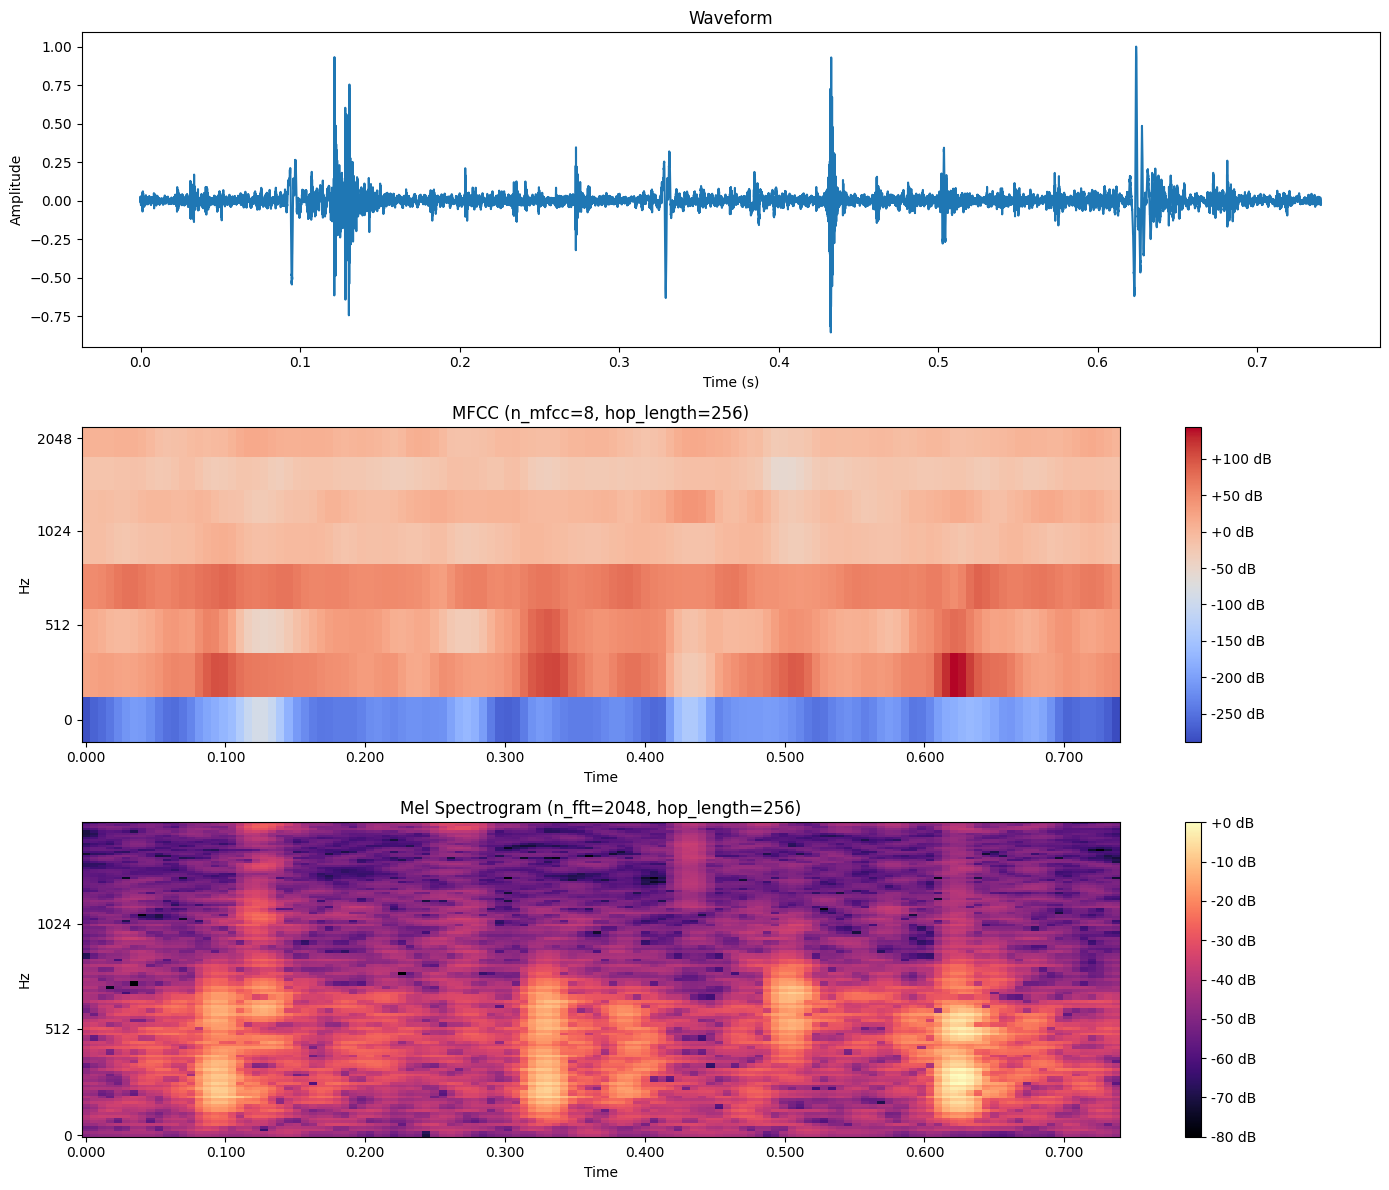

In [50]:
id = 3

# Analyze the first selected anemonefish file with default parameters
# if selected_anemonefish:
#     visualize_audio_features(selected_anemonefish[id])

# # Experiment with increased temporal resolution (decreased hop_length)
# if selected_anemonefish:
#     visualize_audio_features(selected_anemonefish[id], hop_length=128)

# # Experiment with different n_fft values
# if selected_anemonefish:
#     visualize_audio_features(selected_anemonefish[id], n_fft=1024, hop_length=128)

# Experiment with increased vertical resolution (higher n_mfcc)
if selected_anemonefish:
    visualize_audio_features(selected_anemonefish[id], n_mfcc=8, hop_length=256)

### Section 5: Compare Multiple Anemonefish Files

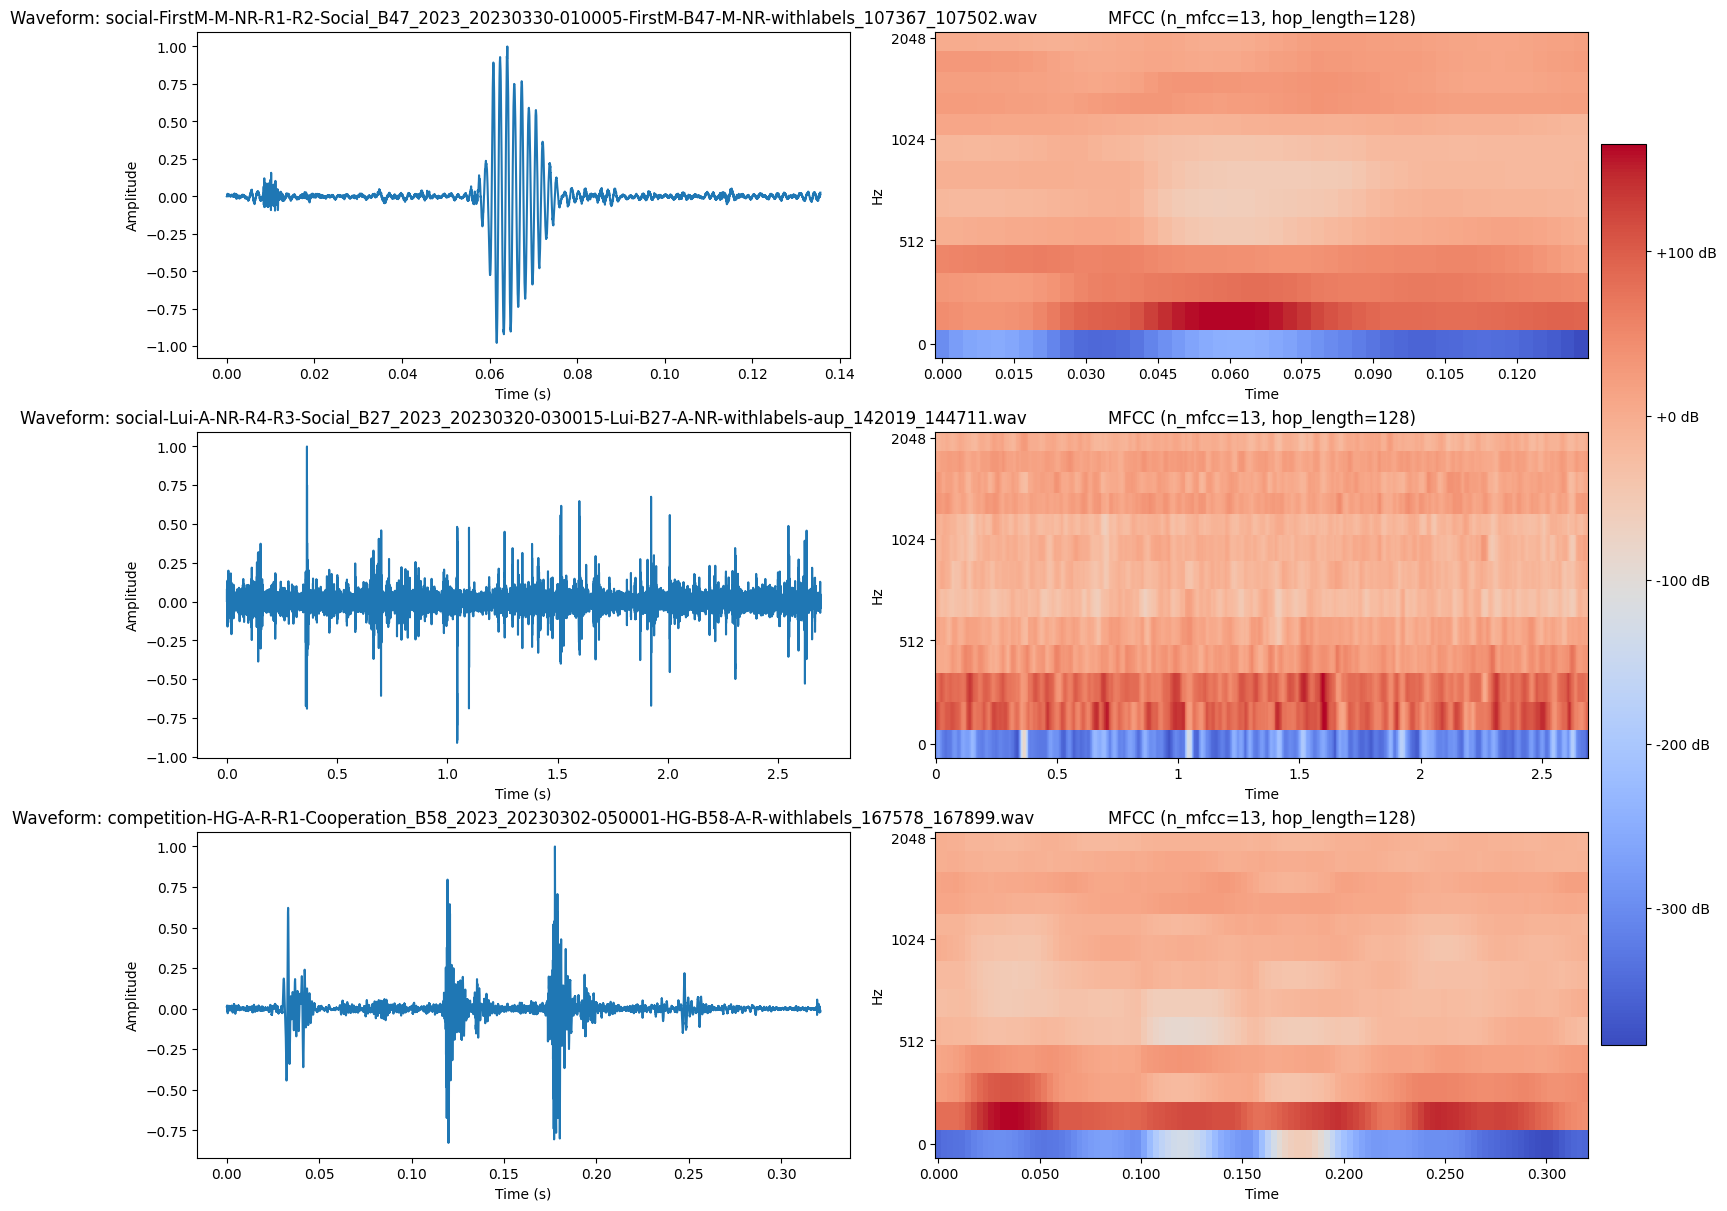

In [56]:
def compare_multiple_files(file_list, n_mfcc=13, n_fft=2048, hop_length=128):
    num_files = len(file_list)
    
    if num_files == 0:
        print("No files to compare")
        return
    
    # Create figure with constrained_layout instead of tight_layout
    fig, axs = plt.subplots(
        num_files, 2, 
        figsize=(16, 4*num_files),  # Increased width and height per file
        constrained_layout=True     # Better automatic layout adjustment
    )
    
    # If only one file, make sure axs is 2D
    if num_files == 1:
        axs = np.array([axs])
    
    # Store the last image for the colorbar
    last_img = None
    
    for i, file_path in enumerate(file_list):
        # Load and process audio
        audio_data, sr = AudioProcessor.load_audio(file_path)
        audio_data = AudioProcessor.normalize_audio(audio_data)
        
        # Extract features with frequency limits for anemonefish
        features = AudioProcessor.extract_features(
            audio_data, sr, 
            n_mfcc=n_mfcc, 
            n_fft=n_fft, 
            hop_length=hop_length
        )
        
        # Plot waveform
        time = np.arange(0, len(audio_data)) / sr
        axs[i, 0].plot(time, audio_data)
        axs[i, 0].set_title(f'Waveform: {os.path.basename(file_path)}')
        axs[i, 0].set_xlabel('Time (s)')
        axs[i, 0].set_ylabel('Amplitude')
        
        # Plot MFCC
        img = librosa.display.specshow(
            features['mfcc'], 
            x_axis='time', 
            y_axis='mel', 
            sr=sr, 
            fmin=0,
            fmax=2000,
            hop_length=hop_length,
            ax=axs[i, 1]
        )
        axs[i, 1].set_title(f'MFCC (n_mfcc={n_mfcc}, hop_length={hop_length})')
        last_img = img
    
    # Add colorbar to the right of the entire figure rather than tied to a specific axes
    fig.colorbar(last_img, ax=axs[:, 1].ravel().tolist(), shrink=0.8, pad=0.02, format='%+2.0f dB')
    
    # No need for tight_layout when using constrained_layout=True
    plt.show()

# Compare the first 3 anemonefish files (or all if less than 3)
files_to_compare = selected_anemonefish[:min(3, len(selected_anemonefish))]
compare_multiple_files(files_to_compare)

### Section 6: Visualizing Noise Data

Found 2184 chunked noise files
File 1: boat_noise_chunk_54.wav
File 2: boat_noise_6_chunk_10.wav
File 3: boat_noise_5_chunk_262.wav
File 4: divers_noise_5_chunk_32.wav
File 5: boat_noise_5_chunk_36.wav
File: boat_noise_chunk_54.wav
Duration: 1.00 seconds
Sample rate: 44100 Hz
Parameters: n_mfcc=20, n_fft=2048, hop_length=128

Feature shapes:
mfcc: (20, 345)
spectral_contrast: (7, 345)
chroma: (12, 345)
rms: (1, 345)


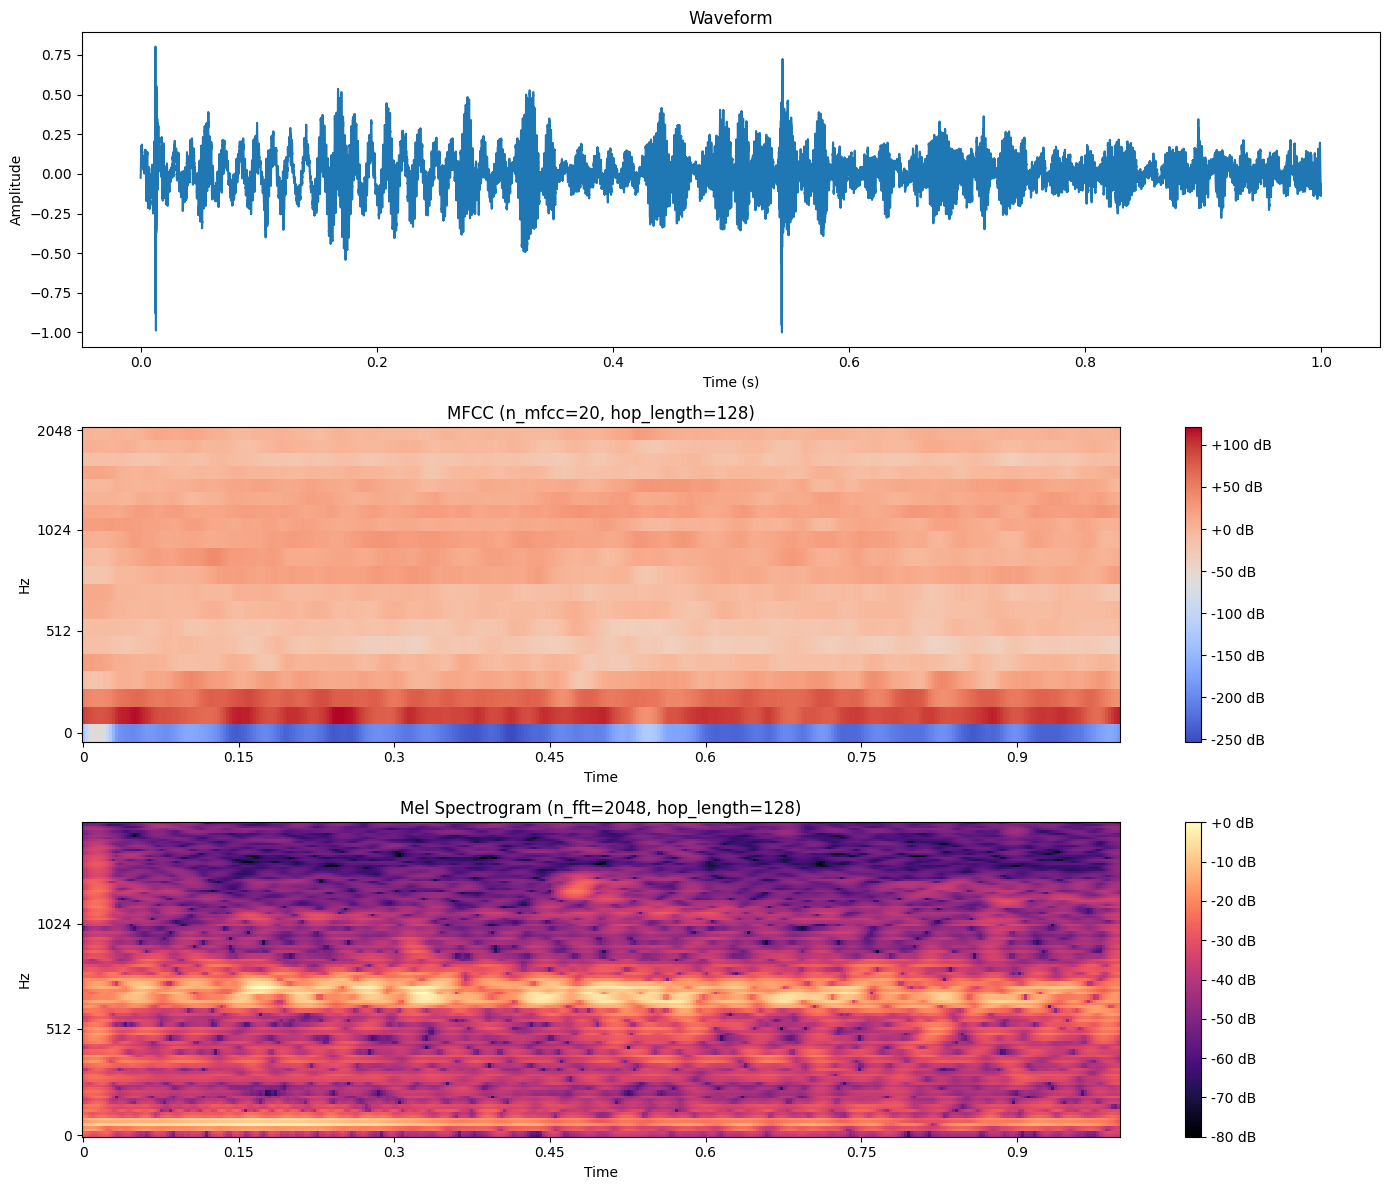

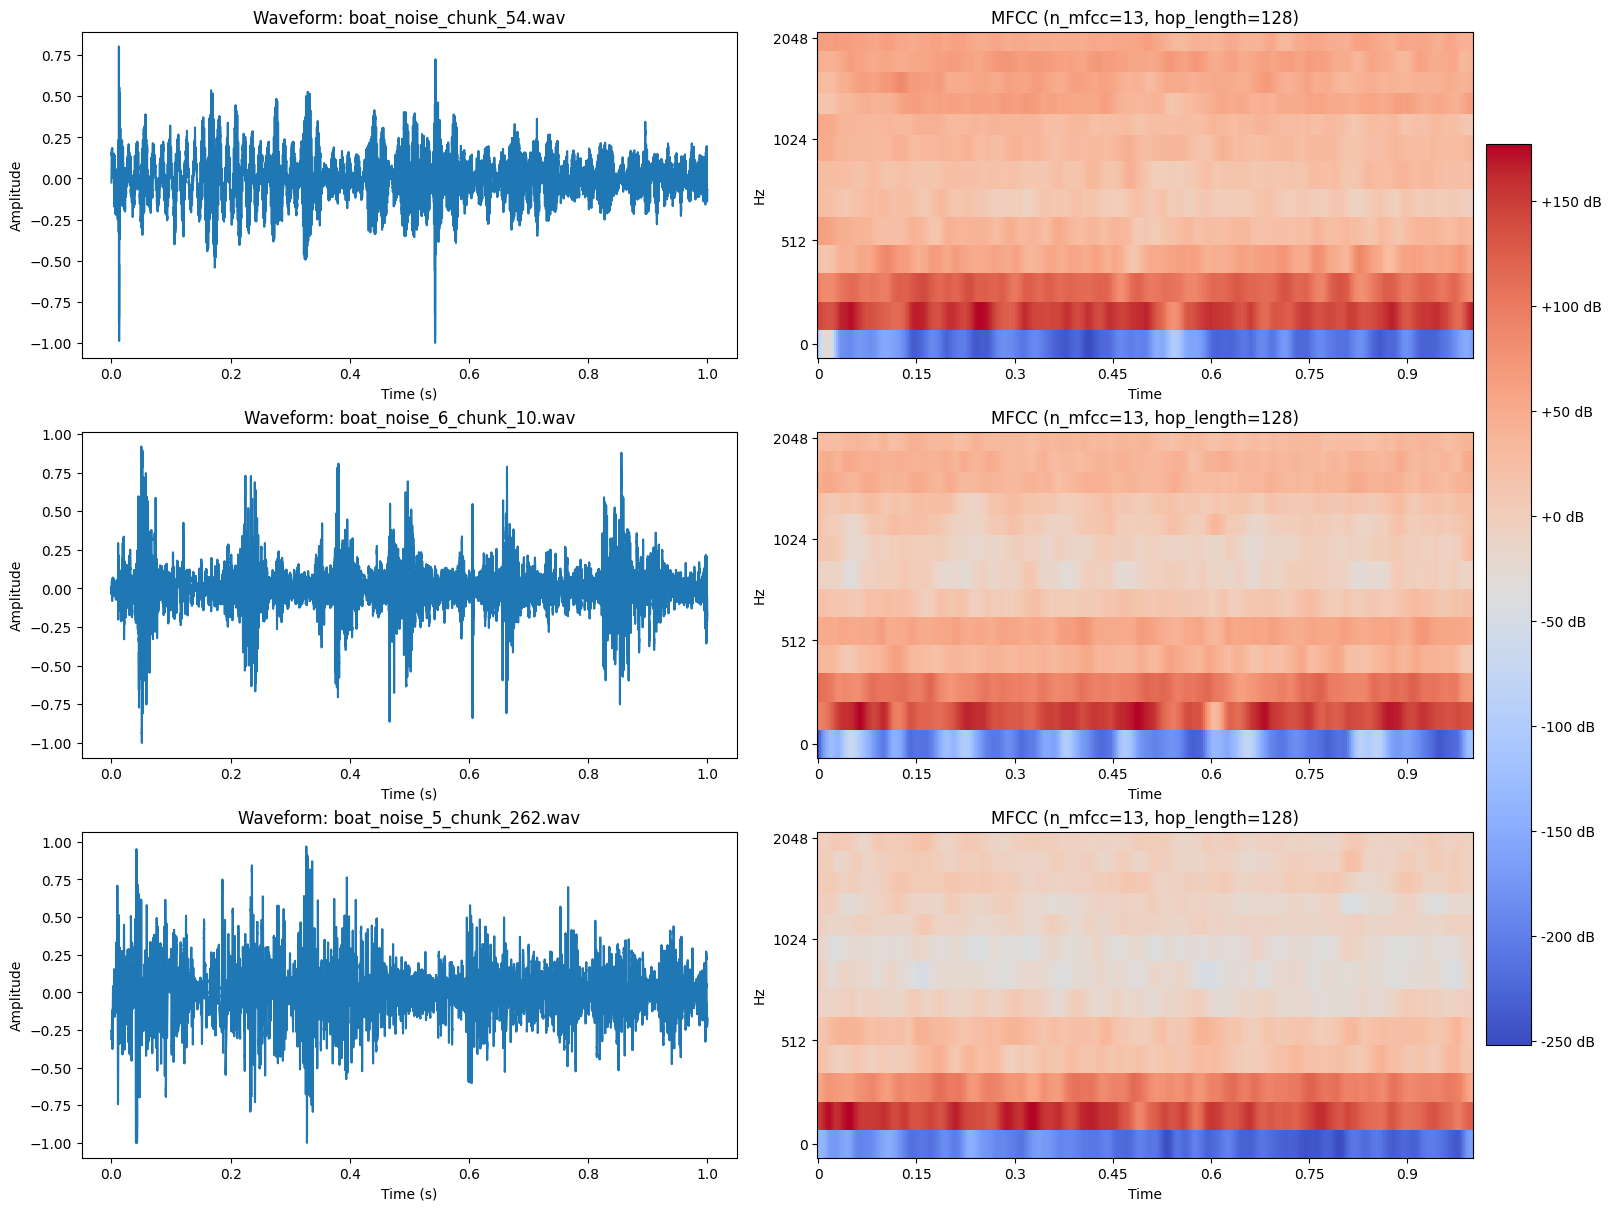

In [57]:
# Get noise files (check if they need to be chunked first)
chunked_noise_files = dataset_builder.list_noise_files(use_chunked=True)
print(f"Found {len(chunked_noise_files)} chunked noise files")

# If no chunked files exist, let's create some
if len(chunked_noise_files) == 0:
    print("No chunked noise files found. Creating chunks now...")
    dataset_builder.chunk_noise_files()
    chunked_noise_files = dataset_builder.list_noise_files(use_chunked=True)
    print(f"Created {len(chunked_noise_files)} chunked noise files")

# Select a few random noise files
num_samples = min(5, len(chunked_noise_files))
selected_noise = random.sample(chunked_noise_files, num_samples)

# Display selected files
for i, file_path in enumerate(selected_noise):
    print(f"File {i+1}: {os.path.basename(file_path)}")

# Analyze the first selected noise file with the optimal parameters
if selected_noise:
    visualize_audio_features(selected_noise[0], n_mfcc=20, hop_length=128)

# Compare multiple noise files side by side
noise_to_compare = selected_noise[:min(3, len(selected_noise))]
compare_multiple_files(noise_to_compare)

### Section 7: Comparing Anemonefish vs Noise

Processing pair 1/3...
Processing pair 2/3...
Processing pair 3/3...
Displaying plot...


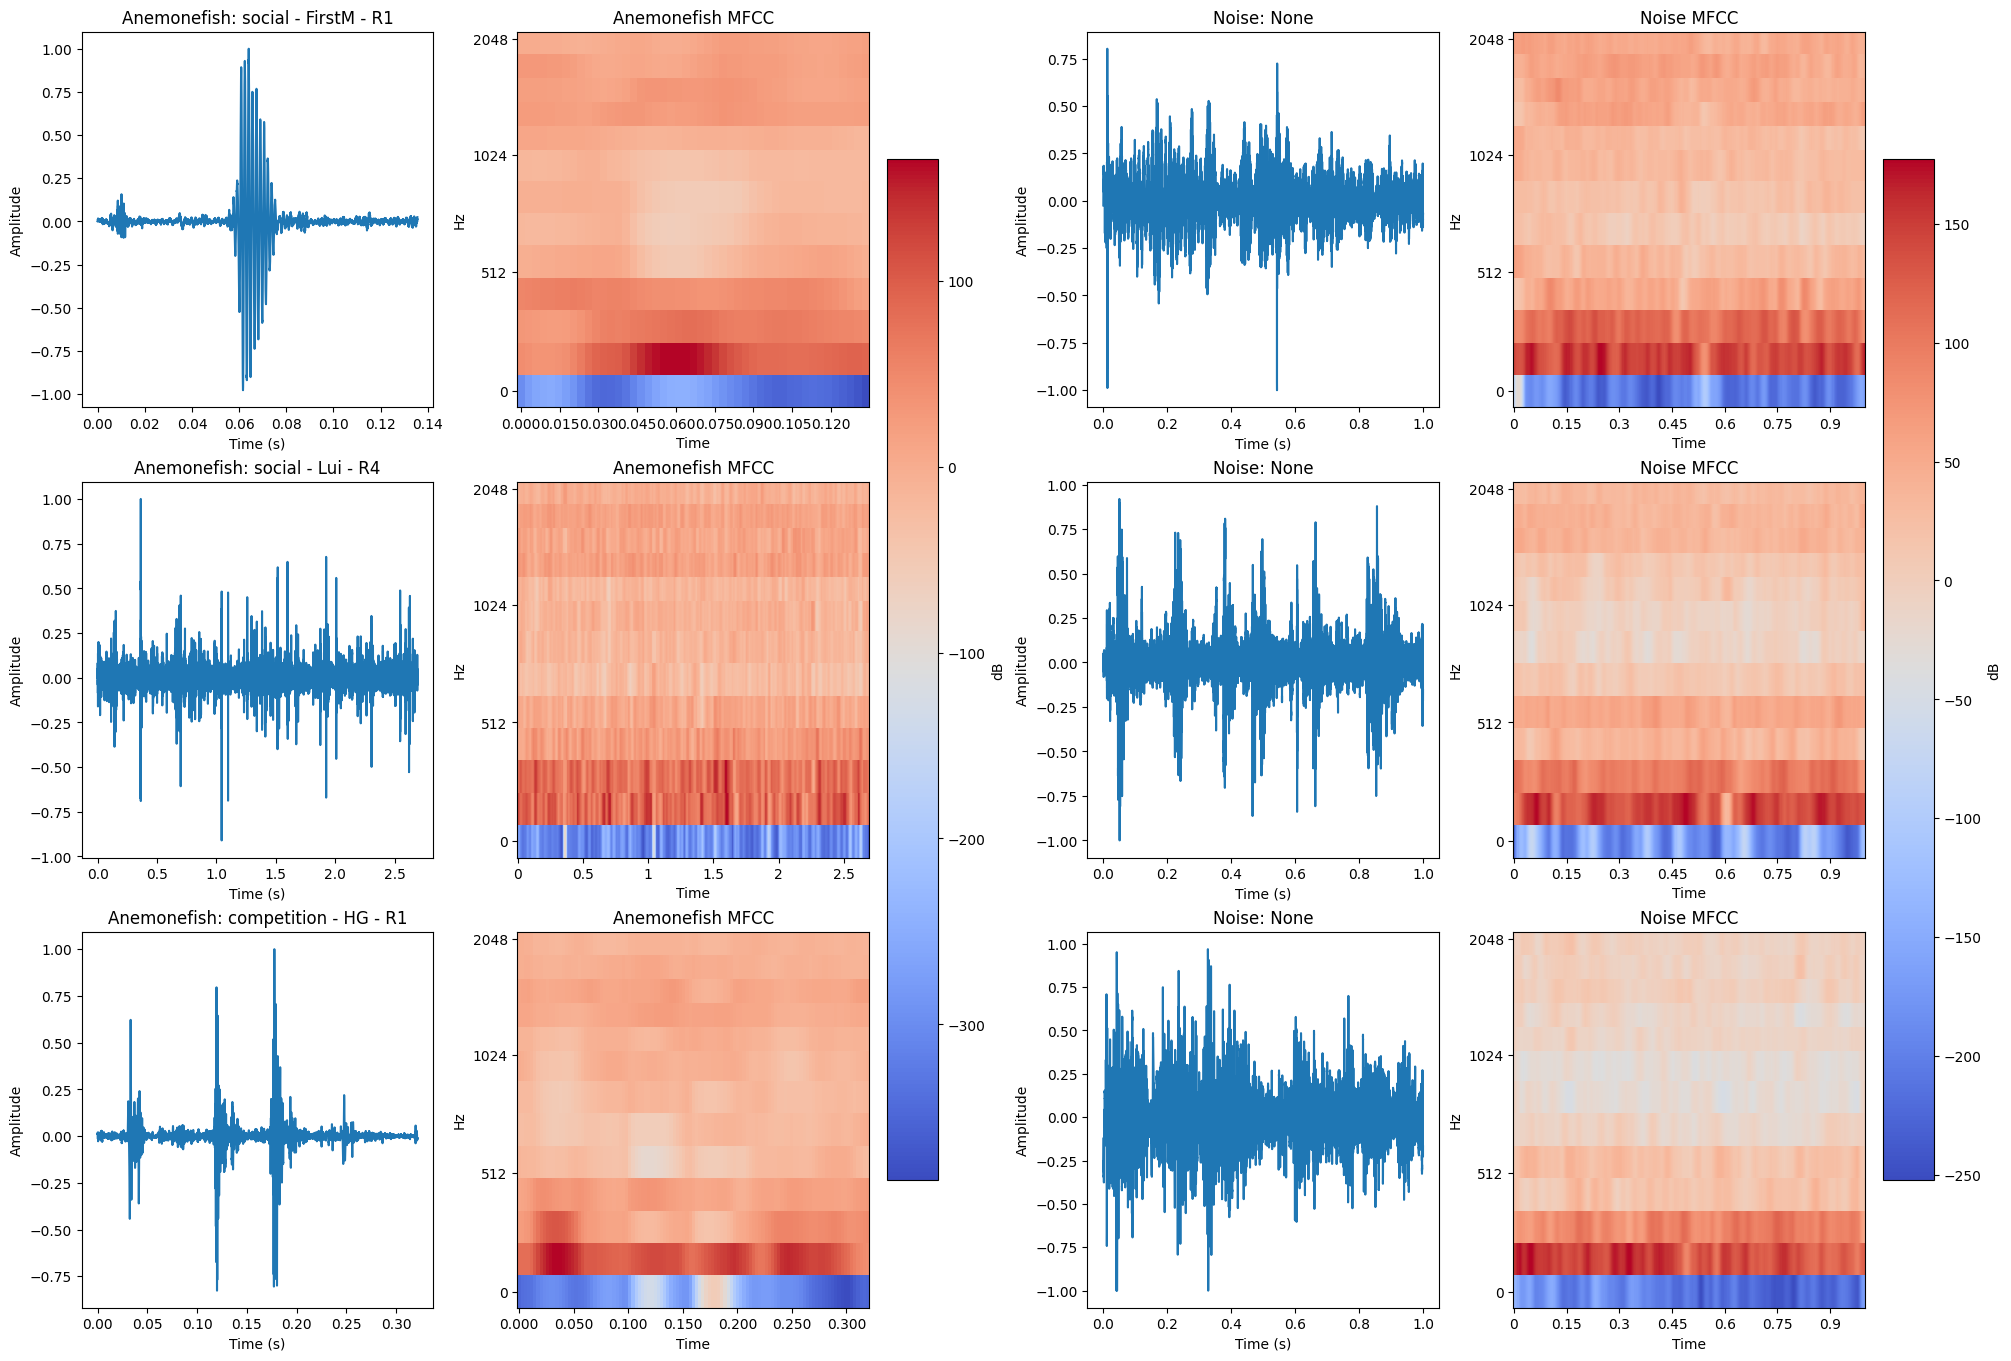

In [62]:
# Function to compare anemonefish and noise files side by side
def compare_anemonefish_vs_noise(anemonefish_files, noise_files, n_mfcc=13, n_fft=2048, hop_length=128):
    num_pairs = min(len(anemonefish_files), len(noise_files))
    
    if num_pairs == 0:
        print("No files to compare")
        return
    
    try:
        # Create figure with subplots
        fig, axs = plt.subplots(num_pairs, 4, figsize=(20, 4.5*num_pairs), constrained_layout=True)
        
        # If only one pair, make sure axs is 2D
        if num_pairs == 1:
            axs = np.array([axs])
        
        # Variables to store the last spectrograms for colorbars
        last_fish_img = None
        last_noise_img = None
        
        for i in range(num_pairs):
            print(f"Processing pair {i+1}/{num_pairs}...")
            
            # Process anemonefish file
            fish_audio, sr_fish = AudioProcessor.load_audio(anemonefish_files[i])
            fish_audio = AudioProcessor.normalize_audio(fish_audio)
            fish_features = AudioProcessor.extract_features(
                fish_audio, sr_fish, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length, 
            )
            
            # Get metadata for anemonefish file
            fish_metadata = AnemoneMetadataParser.parse_filename(anemonefish_files[i])
            fish_title = f"Anemonefish: {fish_metadata.get('behavior_type', 'Unknown')} - {fish_metadata.get('reef', 'Unknown')}"
            if fish_metadata.get('rank'):
                fish_title += f" - {fish_metadata.get('rank')}"
            
            # Process noise file
            noise_audio, sr_noise = AudioProcessor.load_audio(noise_files[i])
            noise_audio = AudioProcessor.normalize_audio(noise_audio)
            noise_features = AudioProcessor.extract_features(
                noise_audio, sr_noise, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length,
            )
            
            # Get metadata for noise file (if it follows the same format)
            try:
                noise_metadata = AnemoneMetadataParser.parse_filename(noise_files[i])
                noise_title = f"Noise: {noise_metadata.get('reef', 'Unknown')}"
                if noise_metadata.get('time_of_day'):
                    noise_title += f" - {noise_metadata.get('time_of_day')}"
            except:
                # If metadata parsing fails, use the basename
                noise_title = f"Noise: {os.path.basename(noise_files[i])}"
            
            # Plot fish waveform
            time_fish = np.arange(0, len(fish_audio)) / sr_fish
            axs[i, 0].plot(time_fish, fish_audio)
            axs[i, 0].set_title(fish_title)
            axs[i, 0].set_xlabel('Time (s)')
            axs[i, 0].set_ylabel('Amplitude')
            
            # Plot fish MFCC
            last_fish_img = librosa.display.specshow(
                fish_features['mfcc'], 
                x_axis='time', 
                y_axis='mel', 
                sr=sr_fish, 
                fmin=0, fmax=2000,  # Focus on anemonefish frequency range
                hop_length=hop_length,
                ax=axs[i, 1]
            )
            axs[i, 1].set_title('Anemonefish MFCC')
            
            # Plot noise waveform
            time_noise = np.arange(0, len(noise_audio)) / sr_noise
            axs[i, 2].plot(time_noise, noise_audio)
            axs[i, 2].set_title(noise_title)
            axs[i, 2].set_xlabel('Time (s)')
            axs[i, 2].set_ylabel('Amplitude')
            
            # Plot noise MFCC
            last_noise_img = librosa.display.specshow(
                noise_features['mfcc'], 
                x_axis='time', 
                y_axis='mel', 
                sr=sr_noise, 
                fmin=0, fmax=2000,  # Focus on anemonefish frequency range
                hop_length=hop_length,
                ax=axs[i, 3]
            )
            axs[i, 3].set_title('Noise MFCC')
        
        # Add colorbars
        if last_fish_img is not None:
            fig.colorbar(last_fish_img, ax=axs[:, 1], shrink=0.8, label='dB')
            
        if last_noise_img is not None:
            fig.colorbar(last_noise_img, ax=axs[:, 3], shrink=0.8, label='dB')
        
        print("Displaying plot...")
        # Removed plt.show() to prevent duplicate display
        return fig
        
    except Exception as e:
        print(f"Error in comparison: {str(e)}")
        import traceback
        traceback.print_exc()
        return None

# Compare a few anemonefish and noise files
pairs_to_compare = min(3, len(selected_anemonefish), len(selected_noise))
fig = compare_anemonefish_vs_noise(
    selected_anemonefish[:pairs_to_compare], 
    selected_noise[:pairs_to_compare]
)
plt.show()  # Show the figure after it's returned

### Section 8: Parameter Exploration Tool

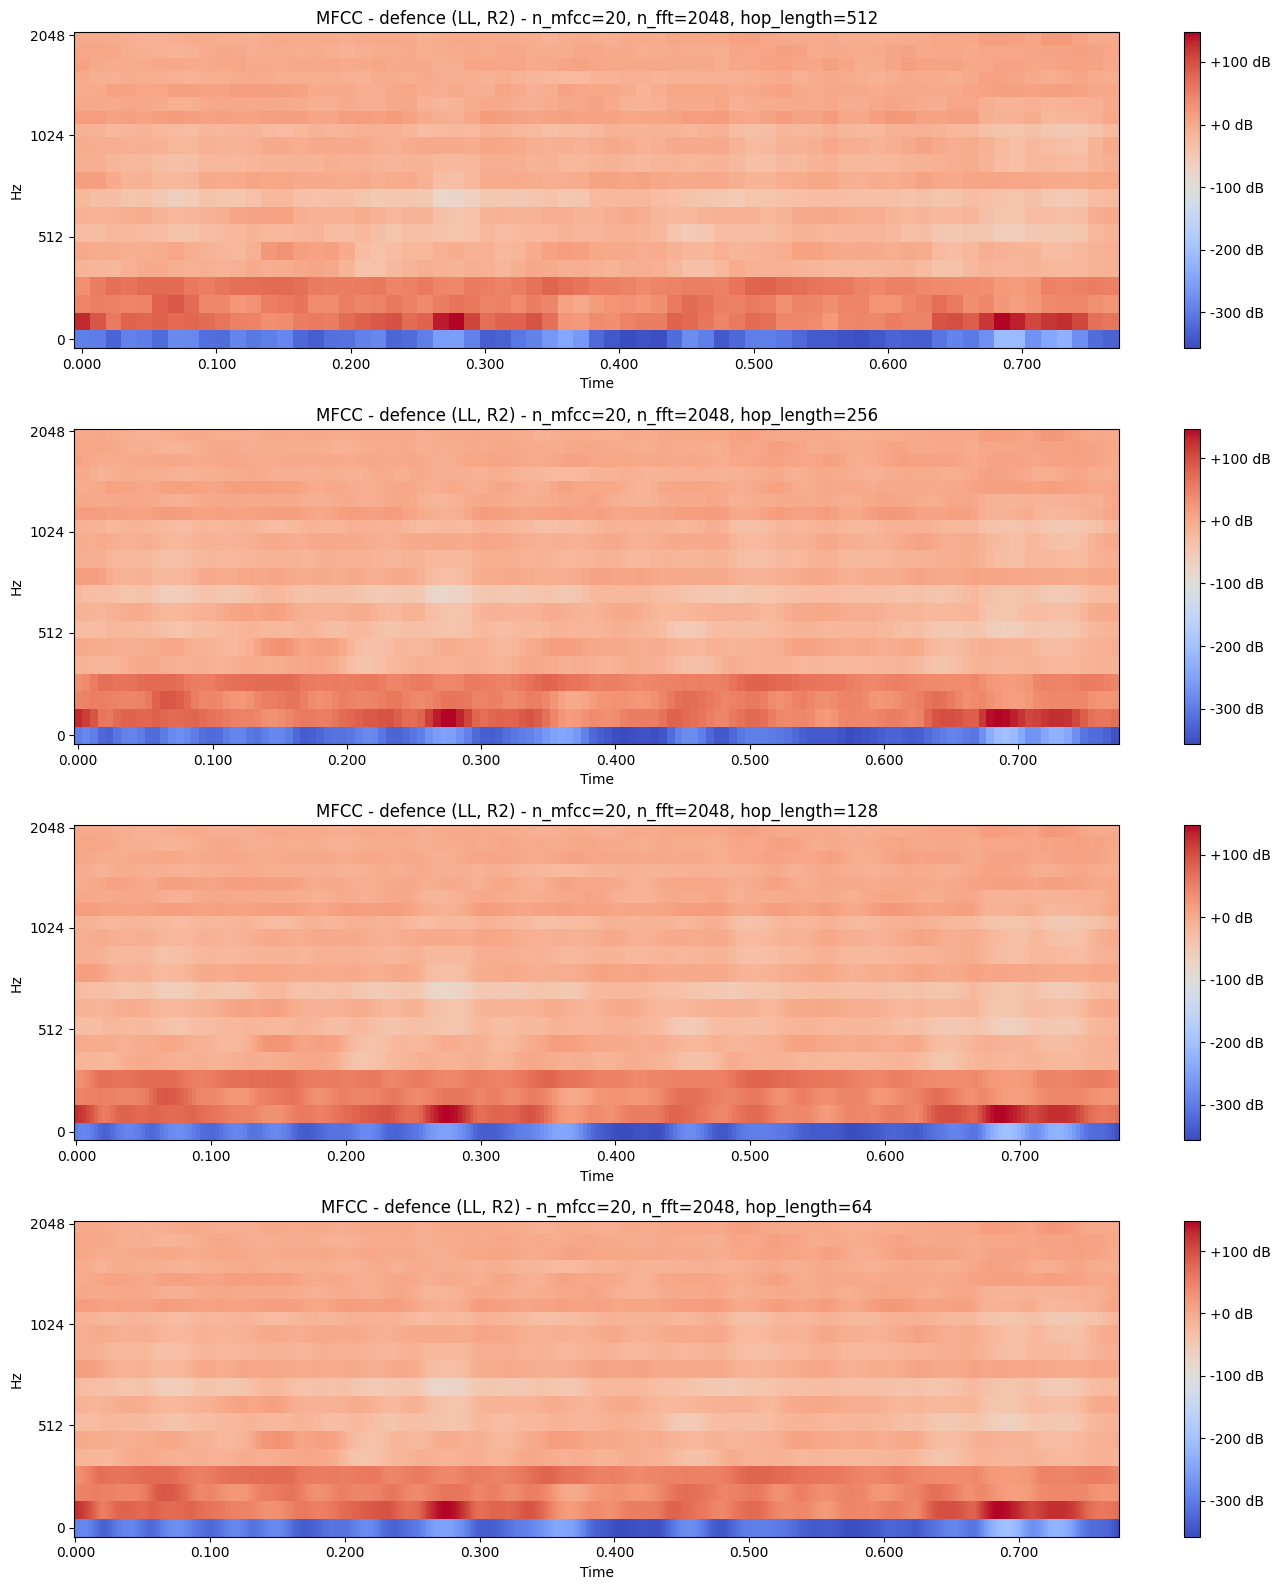


Audio file: defence - LL - R2
Category: Cooperation, ID: B55
Duration: 0.77 seconds
Sample rate: 44100 Hz

Parameters: n_mfcc=20, n_fft=2048, hop_length=512
Feature shapes:
mfcc: (20, 67)
spectral_contrast: (7, 67)
chroma: (12, 67)
rms: (1, 67)

Parameters: n_mfcc=20, n_fft=2048, hop_length=256
Feature shapes:
mfcc: (20, 134)
spectral_contrast: (7, 134)
chroma: (12, 134)
rms: (1, 134)

Parameters: n_mfcc=20, n_fft=2048, hop_length=128
Feature shapes:
mfcc: (20, 267)
spectral_contrast: (7, 267)
chroma: (12, 267)
rms: (1, 267)

Parameters: n_mfcc=20, n_fft=2048, hop_length=64
Feature shapes:
mfcc: (20, 534)
spectral_contrast: (7, 534)
chroma: (12, 534)
rms: (1, 534)


In [69]:
# Define a function for easy parameter testing
def parameter_testing(file_path, param_sets):
    """Test multiple parameter sets on a single file.
    
    Args:
        file_path: Path to the audio file
        param_sets: List of dictionaries with parameters (n_mfcc, n_fft, hop_length)
    """
    # Load audio once
    audio_data, sr = AudioProcessor.load_audio(file_path)
    audio_data = AudioProcessor.normalize_audio(audio_data)
    
    # Parse metadata from filename
    metadata = AnemoneMetadataParser.parse_filename(file_path)
    
    # Create a figure for comparison
    num_params = len(param_sets)
    fig, axs = plt.subplots(num_params, 1, figsize=(14, 4*num_params))
    
    # If only one parameter set, make sure axs is iterable
    if num_params == 1:
        axs = [axs]
    
    for i, params in enumerate(param_sets):
        # Get parameters with defaults
        n_mfcc = params.get('n_mfcc', 20)
        n_fft = params.get('n_fft', 2048)
        hop_length = params.get('hop_length', 512)
        
        # Extract features
        features = AudioProcessor.extract_features(
            audio_data, sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length
        )
        
        # Plot MFCC
        img = librosa.display.specshow(
            features['mfcc'], 
            x_axis='time', 
            y_axis='mel', 
            sr=sr, 
            hop_length=hop_length,
            ax=axs[i],
            fmax=2000,
            fmin=0
        )
        # Enhanced title with metadata information
        axs[i].set_title(f'MFCC - {metadata["behavior_type"]} ({metadata["reef"]}, {metadata["rank"]}) - ' +
                        f'n_mfcc={n_mfcc}, n_fft={n_fft}, hop_length={hop_length}')
        fig.colorbar(img, ax=axs[i], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary with enhanced metadata information
    print(f"\nAudio file: {metadata['behavior_type']} - {metadata['reef']} - {metadata['rank']}")
    print(f"Category: {metadata['category']}, ID: {metadata['id']}")
    print(f"Duration: {len(audio_data)/sr:.2f} seconds")
    print(f"Sample rate: {sr} Hz")
    
    # Print feature shapes for each parameter set
    for params in param_sets:
        n_mfcc = params.get('n_mfcc', 20)
        n_fft = params.get('n_fft', 2048)
        hop_length = params.get('hop_length', 512)
        
        features = AudioProcessor.extract_features(
            audio_data, sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length
        )
        
        print(f"\nParameters: n_mfcc={n_mfcc}, n_fft={n_fft}, hop_length={hop_length}")
        print("Feature shapes:")
        for key, value in features.items():
            print(f"{key}: {value.shape}")

# Test different temporal resolutions on an anemonefish file
if selected_anemonefish:
    parameter_testing(selected_anemonefish[4], [
        {'hop_length': 512},  # Low temporal resolution
        {'hop_length': 256},  # Medium temporal resolution
        {'hop_length': 128},  # High temporal resolution
        {'hop_length': 64}    # Very high temporal resolution
    ])